# Exercise 1: Finding Michel Electrons

Michel electrons come out of a muon decay. They are electrons, so they look like an electromagnetic shower coming out of a long muon track.

```{note}
Need refresh to make sure we get a decent spectrum at the end of the tutorial.
```

### Requirements:
 * U-ResNet for Semantic Segmentation

## I. Motivation

Michel electrons are used in LArTPC experiments as “candles”: we understand their energy spectrum very well, so they can be used to calibrate the detector and to compare the quality of different detectors. Michel electrons spectrum is one of the first “tokens” that an experiment will show to prove that the detector is running and we can successfully reconstruct the data. Since their energy is in a range up to ~50MeV, they are also representative of the detector response to electromagnetic particles generated by neutrino activity.

```{figure} https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQsezzzPeMfyra-aaqqooRh-IAVN61XbgDDuQ&usqp=CAU
Example of Michel electron spectrum
```


### What are we looking for?

```{figure} ./electron_stopping_power.png
---
figclass: margin
---
Energy loss per unit distance (MeV/cm) for electrons traveling in liquid argon. From {cite}`MicrobooneMichel`.
```

The primary Michel electron that comes out of the muon decay-at-rest can lose energy either through ionization (collision stopping power), or through the production of radiative photons via Bremsstrahlung (radiative stopping power). Beyond a certain energy, the radiative stopping power is greater than the collision stopping power. If the radiative photons have enough energy, they can pair-produce, i.e. turn into an electron-positron pair. They, in turn, can produce new radiative photons, and so on. They can also undergo Compton scattering. A cascade of electrons and photons (electromagnetic shower) happens.

Ionization produces track-like energy depositions, whereas the photons can travel some distance before converting into a secondary electron. Hence Michel electrons have two clear topological features: a primary ionization, which is track-like at the end of the muon track, and some scattered energy deposits much further away which come from these radiative photons.

In this exercise, we are only concerned with finding the primary ionization of the Michel electron. We will purposefully ignore for now the radiative photons.

```{figure} ./michel.png
---
height: 300px
---
Example of Michel electron topology
```

## II. Setup

We first need to set the working environment and the path to the validation dataset.

In [1]:
import os, sys
SOFTWARE_DIR = '%s/lartpc_mlreco3d' % os.environ.get('HOME') # Path to your `lartpc_mlreco3d`
DATA_DIR = os.environ.get('DATA_DIR')
# Set software directory
sys.path.append(SOFTWARE_DIR)

### Imports
We will also need ``Plotly`` for visualization, ``Numpy``, ``Pandas`` and other libraries for convenience:

In [2]:
import numpy as np
import pandas as pd
import yaml

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

The imports below load some auxiliary functions and classes required to run the full chain in interactive mode.

In [3]:
import warnings
warnings.filterwarnings('ignore')
from mlreco.main_funcs import process_config, prepare

### Run the full chain (once)
Let’s load the configuration file `inference.cfg` to setup the full chain architecture and weights. This file uses the keyword `DATA_DIR` to symbolize the path to validation set and checkpoint file. We need to replace it with the actual location defined previously.

In [4]:
cfg = yaml.load(open('%s/inference.cfg' % DATA_DIR, 'r').read().replace('DATA_DIR', DATA_DIR),Loader=yaml.Loader)

To keep things simple we will ask the chain to stay quiet and if needed, we can load a bigger dataset than the 100-events default one:

In [5]:
cfg['model']['modules']['chain']['verbose'] = False
# cfg['iotool']['dataset']['data_keys'] = ['/sdf/group/neutrino/ldomine/mpvmpr_012022/test.root']

So far `cfg` was simply a dictionary loaded from a YAML configuration file. It needs to be consumed by a helper function `process_config` to be ready for the full chain usage:

In [6]:
process_config(cfg, verbose=False)


Config processed at: Linux tur012 3.10.0-1160.42.2.el7.x86_64 #1 SMP Tue Sep 7 14:49:57 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"



This next cell loads the dataset and the model to the notebook environment. `hs` stands for "handlers". It contains various useful access points, such as the I/O iterator `hs.data_io_iter` to directly access the dataset or the trainer instance `hs.trainer` which will enable us to actually *run* the network.

In [7]:
# prepare function configures necessary "handlers"
hs = prepare(cfg)
# Optionally, you can specifiy a list of images by listing the image entry ID numbers:
# hs = prepare(cfg, event_list=[0, 1, 2])
dataset = hs.data_io_iter

Welcome to JupyROOT 6.22/09


Loading file: /sdf/home/l/ldomine/lartpc_mlreco3d_tutorials/book/data/mpvmpr_062022_test_small.root
Loading tree sparse3d_reco
Loading tree sparse3d_reco_chi2
Loading tree sparse3d_reco_hit_charge0
Loading tree sparse3d_reco_hit_charge1
Loading tree sparse3d_reco_hit_charge2
Loading tree sparse3d_reco_hit_key0
Loading tree sparse3d_reco_hit_key1
Loading tree sparse3d_reco_hit_key2
Loading tree sparse3d_pcluster_semantics_ghost
Loading tree cluster3d_pcluster
Loading tree particle_pcluster
Loading tree particle_mpv
Loading tree sparse3d_pcluster_semantics
Loading tree sparse3d_pcluster
Loading tree particle_corrected
Found 101 events in file(s)


Warning in <TClass::Init>: no dictionary for class larcv::EventNeutrino is available
Warning in <TClass::Init>: no dictionary for class larcv::NeutrinoSet is available
Warning in <TClass::Init>: no dictionary for class larcv::Neutrino is available


Freezing 82 weights for a sub-module ppn


Freezing 141 weights for a sub-module uresnet_lonely


Freezing 141 weights for a sub-module uresnet_deghost


Freezing 146 weights for a sub-module graph_spice


Freezing 120 weights for a sub-module grappa_track


Freezing 120 weights for a sub-module grappa_shower


Restoring weights for  from /sdf/home/l/ldomine/lartpc_mlreco3d_tutorials/book/data/weights_full_mpvmpr_062022.ckpt...


Done.


If the model’s trained weights have been loaded correctly, this should have displayed a message like this (`$PATH_TO_WEIGHTS` will be replaced by wherever you placed your trained full chain weights):

> Restoring weights for from `$PATH_TO_WEIGHTS`… Done.

We are now all set to perform **one forward iteration** of the chain as follows:

In [8]:
data, result = hs.trainer.forward(dataset)

The input data and label information are loaded onto the `data` variable, while the outputs from the chain are stored inside `result`. We will use the output of this single iteration to demonstrate a simple Michel electron selection, before running with higher statistics (ie. performing many more iterations).

## III. Setup the Evaluator

For the tutorial, we will use the analysis tools developed for easier handling of the full chain outputs.

In [9]:
from analysis.classes.ui import FullChainEvaluator

Let’s setup the FullChainEvaluator with deghosting turned on. We also want to make sure true Michel electron are limited to their primary ionization by definition.

In [10]:
predictor = FullChainEvaluator(data, result, cfg, deghosting=True, processor_cfg={'michel_primary_ionization_only': True, 'min_overlap': 5, 'overlap_mode': 'counts'})

For explanations purpose we picked an entry that has a Michel electron:

In [11]:
entry = 3

## IV. Selecting Michel Electrons

### Visualizing true and predicted particles

Let’s first import plotting functions from `lartpc_mlreco3d` for easier visualization:

In [12]:
from mlreco.visualization import scatter_points, scatter_cubes, plotly_layout3d
from mlreco.visualization.plotly_layouts import white_layout, trace_particles, trace_interactions, dualplot

By default, the label for tracks and michel electrons are 1 and 2, respectively.

In [13]:
track_label = 1
michel_label = 2

We set `only_primaries=False` to not be limited to primary particles only (i.e. particles coming out of a neutrino-like interaction vertex, in our sample that would be a MultiParticleVertex (MPV) interaction as opposed to MultiParticleRain (MPR)).

In [14]:
particles = predictor.get_particles(entry, only_primaries=False)
true_particles = predictor.get_true_particles(entry, only_primaries=False, verbose=False)

These are simple lists of particles, so you could print them out to take a quick look:

In [15]:
particles

[Particle( Image ID=0   | Particle ID=1   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 1  | Score = 99.73% | Interaction ID: 2  | Size: 250   ),
 Particle( Image ID=0   | Particle ID=2   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 1  | Score = 99.94% | Interaction ID: 2  | Size: 161   ),
 Particle( Image ID=0   | Particle ID=3   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 0  | Score = 54.76% | Interaction ID: 12 | Size: 22    ),
 Particle( Image ID=0   | Particle ID=4   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 0  | Score = 84.88% | Interaction ID: 17 | Size: 35    ),
 Particle( Image ID=0   | Particle ID=5   | Semantic_type: Track           | PID: Muon     | Primary: 0  | Score = 53.54% | Interaction ID: 5  | Size: 584   ),
 Particle( Image ID=0   | Particle ID=6   | Semantic_type: Track           | PID: Muon     | Primary: 0  | Score = 49.14% | Interaction ID: 6  | Size: 910   ),
 Particle( Image ID=0   | Particle ID=7 

In [16]:
true_particles

[TruthParticle( Image ID=0   | Particle ID=0   | Semantic_type: Shower Fragment | PID: Electron | Primary: 1  | Interaction ID: 9  | Size: 236   ),
 TruthParticle( Image ID=0   | Particle ID=1   | Semantic_type: Track           | PID: Proton   | Primary: 1  | Interaction ID: 9  | Size: 277   ),
 TruthParticle( Image ID=0   | Particle ID=2   | Semantic_type: Track           | PID: Proton   | Primary: 1  | Interaction ID: 9  | Size: 140   ),
 TruthParticle( Image ID=0   | Particle ID=3   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 1  | Interaction ID: 9  | Size: 163   ),
 TruthParticle( Image ID=0   | Particle ID=4   | Semantic_type: Shower Fragment | PID: Photon   | Primary: 1  | Interaction ID: 9  | Size: 250   ),
 TruthParticle( Image ID=0   | Particle ID=13  | Semantic_type: Track           | PID: Muon     | Primary: 1  | Interaction ID: 5  | Size: 1044  ),
 TruthParticle( Image ID=0   | Particle ID=14  | Semantic_type: Track           | PID: Muon     | Primary: 1  | 

You see that we have a Michel electron among both true and predicted particles. Let's visualize both of these sets of particles: we create "traces" for Plotly with each set and plot the result.

In [17]:
trace1 = trace_particles(particles)
trace2 = trace_particles(true_particles)

The left plot shows predicted particles, the right plot shows true particles. The colors are arbitrary and represent the cluster id.

In [18]:
fig = dualplot(trace1, trace2, titles=['Predicted particles (predicted no-ghost mask)', 'True particles (predicted no-ghost mask)'])

iplot(fig)

Ok, so we can rotate the images around and confirm that there is one predicted and true Michel electron in this image.

### Selecting Michel candidates
**Criteria 1: is attached to muon**
To check if our candidate michel is actually adjacent to a track, we will set a minimum distance threshold (`attached_threshold`) between the Michel electron and the track.

> Wait, what if it was a misclassified Delta ray electron?

Delta ray electrons are knock off electrons that can happen along the trajectory of a muon, so if UResNet mispredicted the delta ray voxels as Michel voxels we would be wrong! To avoid that, let’s also make sure that the point of contact is at the end of the track.

**Criteria 2: is at the edge of muon**
Again, many ways to do this check, this is just one possible heuristic. We will do an *ablation* study: remove all muon voxels within a certain radius (`ablation_radius`) from the touching point, and compare the DBSCAN cluster count before and after ablation. DBSCAN needs two parameters to run (`ablation_eps` is a distance within which voxels get clustered together by DBSCAN, and `ablation_min_samples` is the minimal cluster voxel count). If the cluster count delta is $\leq 1$, we declare the test successful: the Michel electron is at the edge of the muon.

In [19]:
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

def is_attached_at_edge(points1, points2,
                        attached_threshold=5,
                        ablation_eps=5,
                        ablation_radius=15,
                        ablation_min_samples=5):
    """
    Checks whether the cluster of coordinates points1
    is attached at the edge of the cluster points2.

    Parameters
    ==========
    points1: np.ndarray (M, 3)
    points2: np.ndarray (N, 3)

    Returns
    =======
    bool
    """
    #
    # Criteria 1: is it attached to the muon?
    #
    distances = cdist(points1, points2)
    is_attached = np.min(distances) < attached_threshold

    #
    # Criteria 2: is it at the edge of the muon?
    #

    # Find the touching point
    Michel_min, MIP_min = np.unravel_index(np.argmin(distances), distances.shape)
    min_coords = points2[MIP_min, :]
    # Define muon voxels after ablation
    ablated_cluster = points2[np.linalg.norm(points2-min_coords, axis=1) > ablation_radius]
    # Run DBSCAN before and after ablation
    new_cluster_count, old_cluster_count = 0, 1
    if ablated_cluster.shape[0] > 0:
        dbscan = DBSCAN(eps=ablation_eps, min_samples=ablation_min_samples)
        old_cluster = dbscan.fit(points2).labels_
        new_cluster = dbscan.fit(ablated_cluster).labels_
        # If only one cluster is left, we were at the edge
        # (accounts for case where a track is fragmented
        # and put together by Track GNN)
        is_edge = (old_cluster_count - new_cluster_count) <= 1 and old_cluster_count >= new_cluster_count
    else: # if nothing is left after ablating, this might be a really small muon... calling it the edge
        is_edge = True

    return is_attached and is_edge

**Selection = criteria 1 + criteria 2**

Now our actual selection code is very simple: pick predicted Michel particles and check whether they meet this criteria (attached at the edge of a predicted muon). Here is a good starting point for the parameters mentioned in the two criterias definition above:

In [20]:
attached_threshold = 10
ablation_eps = 10
ablation_radius = 15
ablation_min_samples = 5

In [21]:
def get_michels(particles):
    """
    Parameters
    ==========
    particles: list of Particle

    Returns
    =======
    list of Particle
    """
    selected_michels = []
    for p in particles:
        if p.semantic_type != michel_label: continue

        # Check whether it is attached to the edge of a track
        michel_is_attached_at_edge = False
        for p2 in particles:
            if p2.semantic_type != track_label: continue
            if not is_attached_at_edge(p.points, p2.points,
                                    attached_threshold=attached_threshold,
                                    ablation_eps=ablation_eps,
                                    ablation_radius=ablation_radius,
                                    ablation_min_samples=ablation_min_samples): continue
            michel_is_attached_at_edge = True
            break

        # Require that the Michel is attached at the edge of a track
        if not michel_is_attached_at_edge: continue

        selected_michels.append(p)

    return selected_michels

We do successfully isolate the only Michel in this specific event:

In [22]:
selected_michels = get_michels(particles)
selected_michels

[Particle( Image ID=0   | Particle ID=18  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Score = 67.58% | Interaction ID: 11 | Size: 118   ),
 Particle( Image ID=0   | Particle ID=19  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Score = 51.56% | Interaction ID: 12 | Size: 133   ),
 Particle( Image ID=0   | Particle ID=20  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Score = 51.32% | Interaction ID: 17 | Size: 124   )]

A good cross-check is to run the same selection on the true particles and confirm that it selects the known true Michel in this event

In [23]:
get_michels(true_particles)

[TruthParticle( Image ID=0   | Particle ID=22  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Interaction ID: 4  | Size: 118   ),
 TruthParticle( Image ID=0   | Particle ID=23  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Interaction ID: 6  | Size: 124   ),
 TruthParticle( Image ID=0   | Particle ID=26  | Semantic_type: Michel Electron | PID: Electron | Primary: 0  | Interaction ID: 7  | Size: 133   )]

### Matching with true Michel electrons

Although it seems pretty obvious in this specific event, we want to systematically match predicted and true Michel particles. We first have to match all particles with one another in the entire event. Earlier when I defined the predictor I have asked that two particles have at least 5 voxels overlap (`min_overlap`) with each other before a match can be declared.

In [24]:
matched_particles = predictor.match_particles(entry, mode='pred_to_true')

Now we will loop over previously selected Michel candidates and record voxel count and voxel sum for both the predicted Michel and its matched true Michel:

In [25]:
def fill_dataframe(selected_michels, matched_particles):

    michels = {
        "pred_num_pix": [],
        "pred_sum_pix": [],
        "true_num_pix": [],
        "true_sum_pix": [],
        "true_noghost_primary_num_pix": [],
        "true_noghost_primary_sum_pix": []
    }

    for p in selected_michels:
        michels["pred_num_pix"].append(p.size)
        michels["pred_sum_pix"].append(p.depositions.sum())

        michels["true_num_pix"].append(-1)
        michels["true_sum_pix"].append(-1)
        michels["true_noghost_primary_num_pix"].append(-1)
        michels["true_noghost_primary_sum_pix"].append(-1)
        for mp in matched_particles: # matching is done true2pred
            if mp[0] is None or mp[0].id != p.id: continue
            if mp[1] is None: continue
            m = mp[1]        
            michels["true_num_pix"][-1] = m.size
            michels["true_sum_pix"][-1] = m.depositions.sum()

            michels["true_noghost_primary_num_pix"][-1] = m.coords_noghost.shape[0]
            michels["true_noghost_primary_sum_pix"][-1] = m.depositions_noghost.sum()

    michels = pd.DataFrame(michels)
    return michels

In [26]:
fill_dataframe(selected_michels, matched_particles)

pred_num_pix  pred_sum_pix  true_num_pix  true_sum_pix  \
0           118   9148.559156           118   9148.559156   
1           133   7273.212998           133   7273.212998   
2           124  11457.933639           124  11457.933639   

   true_noghost_primary_num_pix  true_noghost_primary_sum_pix  
0                           126                     33.723743  
1                           133                     22.980205  
2                           117                     31.621221

Yay, we were able to match the predicted and true Michel particles and record all necessary information to make a spectrum plot.

### Repeat with high statistics
One entry won't get us a very nice-looking spectrum, so we need to repeat this analysis enough times:

In [27]:
michels = pd.DataFrame({
        "index": [],
        "pred_num_pix": [],
        "pred_sum_pix": [],
        "true_num_pix": [],
        "true_sum_pix": [],
        "true_noghost_primary_num_pix": [],
        "true_noghost_primary_sum_pix": []
    })

N_true_michel = 0

from tqdm import tqdm
for iteration in tqdm(range(10)):
    #print("Iteration: {}...".format(iteration))
    data, result = hs.trainer.forward(dataset)
    predictor = FullChainEvaluator(data, result, cfg, deghosting=True, processor_cfg={'michel_primary_ionization_only': True, 'min_overlap': 5, 'overlap_mode': 'counts'})
    for entry, index in enumerate(predictor.index):
        particles = predictor.get_particles(entry, only_primaries=False)
        selected_michels = get_michels(particles)
        matched_particles = predictor.match_particles(entry, mode='pred_to_true')
        df = fill_dataframe(selected_michels, matched_particles)
        df['index'] = index
        #print(df)
        #michels.merge(how='left')
        michels = pd.concat([michels, df])

        # count true Michels
        true_particles = predictor.get_true_particles(entry, only_primaries=False, verbose=False)
        N_true_michel += np.count_nonzero([tp.semantic_type == michel_label for tp in true_particles])

  0%|                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

 10%|██████████████▏                                                                                                                               | 1/10 [00:39<05:53, 39.31s/it]

 20%|████████████████████████████▍                                                                                                                 | 2/10 [01:15<04:59, 37.49s/it]

 30%|██████████████████████████████████████████▌                                                                                                   | 3/10 [01:56<04:33, 39.08s/it]

 40%|████████████████████████████████████████████████████████▊                                                                                     | 4/10 [02:29<03:40, 36.71s/it]

 50%|███████████████████████████████████████████████████████████████████████                                                                       | 5/10 [02:56<02:46, 33.35s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6/10 [03:33<02:18, 34.60s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7/10 [04:04<01:39, 33.16s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8/10 [04:47<01:12, 36.40s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9/10 [05:19<00:35, 35.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:21<00:00, 24.88s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:21<00:00, 32.18s/it]

## Selection quality checks

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

Let's see how many Michel electron candidates we found:

In [29]:
N_pred = michels.shape[0]
N_matched = np.count_nonzero(michels['true_num_pix'] > -1)
N_true = N_true_michel
print("Number of predicted candidate Michel electrons = ", N_pred)
print("Number of matched predicted candidate Michel electrons = ", N_matched)
print("Number of true Michel electrons = ", N_true)
print("Identification purity = %.2f %%" % (100* N_matched / N_pred))
print("Identification efficiency = %.2f %%" % (100 * N_matched / N_true))

Number of predicted candidate Michel electrons =  210
Number of matched predicted candidate Michel electrons =  209
Number of true Michel electrons =  216
Identification purity = 99.52 %
Identification efficiency = 96.76 %


Note: It is not impossible that several predicted Michel would get matched to the same true Michel cluster.

We can also get a first rough idea of how well we reconstructed the Michel electrons by comparing predicted and true voxel counts (here, the true voxel count is taken after the deghosting stage, i.e. it does not factor the deghosting performance):

Text(0, 0.5, 'Pixels in candidate Michel cluster')

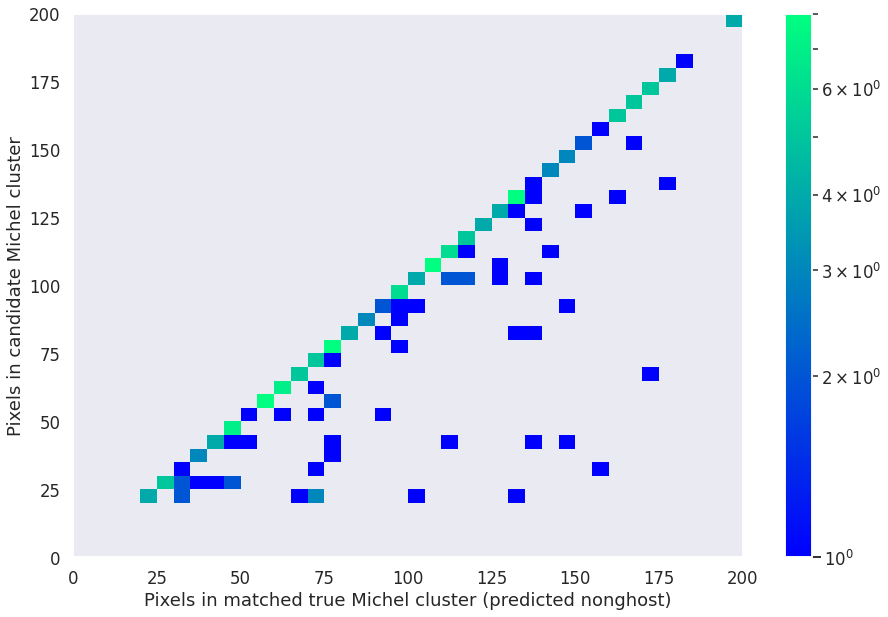

In [30]:
plt.hist2d(michels['true_num_pix'],
          michels['pred_num_pix'],
          bins=[40, 40], range=[[0, 200], [0, 200]], cmap='winter', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('Pixels in matched true Michel cluster (predicted nonghost)')
plt.ylabel('Pixels in candidate Michel cluster')

## Michel spectrum
This is a helper function to plot boxes later:

In [31]:
# Function to plot error boxes
def makeErrorBoxes(ax, xdata,ydata,xerror,yerror,fc='r',ec='None',alpha=0.5):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye in zip(xdata,ydata,xerror.T,yerror.T):
        rect = matplotlib.patches.Rectangle((xc-xe/2.0,yc-ye/2.0),xe,ye)
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = matplotlib.collections.PatchCollection(errorboxes,facecolor=fc,alpha=alpha,edgecolor=ec, label='Primary ionization')

    # Add collection to axes
    ax.add_collection(pc)

In [32]:
def plot_michel_spectrum(michels, mode='num', min_range=0, max_range=250, bins=20):
    assert mode == 'num' or mode == 'sum'

    entries, edges, _ = plt.hist(michels['true_noghost_primary_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    entries3, edges3, _ = plt.hist(michels['true_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers3 = 0.5 * (edges3[:-1] + edges3[1:])   

    entries2, edges2, _ = plt.hist(michels['pred_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers2 = 0.5 * (edges2[:-1] + edges2[1:])

    plt.clf()
    #h1 = plt.hist(michels['michel_true_num_voxels'], bins=bins, range=[0, max_range], label='True Michel', alpha=0.5, histtype='step')
    h2 = plt.errorbar(bin_centers2, entries2, yerr=np.sqrt(entries2), fmt='.', label='Predicted candidate Michel electron')

    makeErrorBoxes(plt.gca(), bin_centers,entries,np.ones_like(bin_centers)*max_range/bins,np.sqrt(entries), fc='g')
    makeErrorBoxes(plt.gca(), bin_centers3,entries3,np.ones_like(bin_centers3)*max_range/bins,np.sqrt(entries3), fc='orange')

    pc = matplotlib.patches.Patch(color='green', label='Primary ionization (true non-ghost)', alpha=0.4, linewidth=0.0)
    pc3 = matplotlib.patches.Patch(color='orange', label='Primary ionization (predicted non-ghost)', alpha=0.4, linewidth=0.0)
    handles, labels = plt.gca().get_legend_handles_labels()

    if mode == 'num':
        handles = handles+[pc, pc3]
    else:
        handles = handles+[pc3]
    plt.legend(handles=handles, labels=labels+['True primary ionization (true non-ghost mask)', 'True primary ionization (predicted non-ghost mask)'])

    #plt.legend()
    plt.xlabel('Number of pixels' if mode == 'num' else 'Sum of pixels')
    plt.ylabel('Michel electrons clusters')
    #plt.ylim(0, 200)
    plt.xlim(min_range, max_range)

### Pixel count spectrum

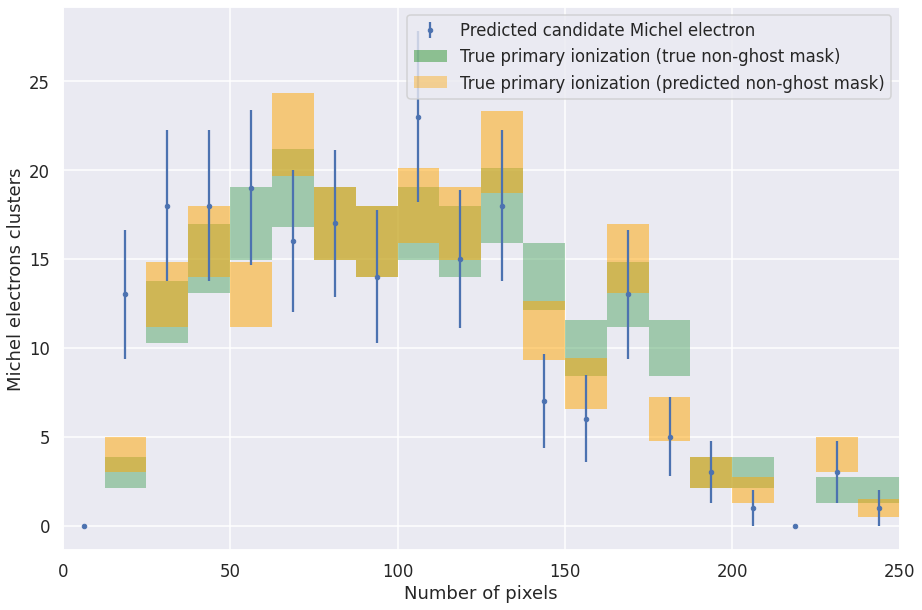

In [33]:
plot_michel_spectrum(michels, mode='num')

### Pixel sum spectrum

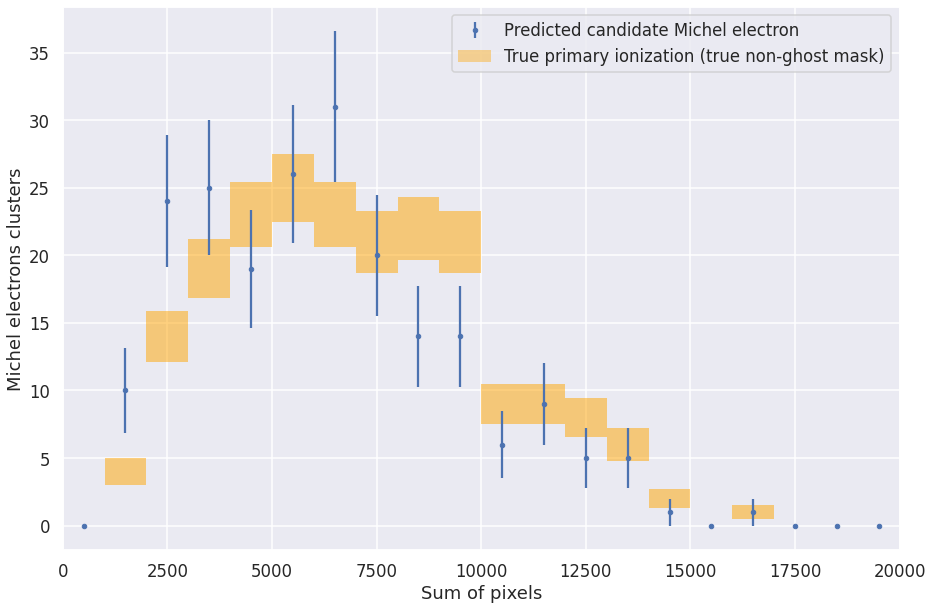

In [34]:
plot_michel_spectrum(michels, mode='sum', max_range=2e4)

## Other readings
Michel Electron Reconstruction Using
Cosmic-Ray Data from the MicroBooNE LArTPC
https://lss.fnal.gov/archive/2017/pub/fermilab-pub-17-090-nd.pdf


```{bibliography}
:style: alpha
```